In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [3]:
path_inception = f"{getcwd()}/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = path_inception

pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                               include_top=False,
                               weights=None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False
  
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [4]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output


last layer output shape:  (None, 7, 7, 768)


In [5]:
# Define a Callback class that stops training once accuracy reaches 90.0%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90.0% accuracy so cancelling training!")
      self.model.stop_training = True

In [12]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 2048 hidden units and ReLU activation
x = layers.Dense(2048, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(5, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '/content/dataset_resized.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

In [14]:
# Define our example directories and files
train_dir = '/tmp/dataset_resized/training_set'
validation_dir = '/tmp/dataset_resized/validation_set'

train_drawings = os.path.join(train_dir+'/drawings')
train_engraving = os.path.join(train_dir+'/engraving')
train_iconography = os.path.join(train_dir+'/iconography')
train_painting = os.path.join(train_dir+'/painting')
train_sculpture = os.path.join(train_dir+'/sculpture')
validation_drawings = os.path.join(validation_dir+'/drawings')
validation_engraving = os.path.join(validation_dir+'/engraving')
validation_iconography = os.path.join(validation_dir+'/iconography')
validation_painting = os.path.join(validation_dir+'/painting')
validation_sculpture = os.path.join(validation_dir+'/sculpture')

train_drawings_fnames = os.listdir(train_drawings)
train_engraving_fnames = os.listdir(train_engraving)
train_iconography_fnames = os.listdir(train_iconography)
train_painting_fnames = os.listdir(train_painting)
train_sculpture_fnames = os.listdir(train_sculpture)
validation_drawings_fnames = os.listdir(validation_drawings)
validation_engraving_fnames = os.listdir(validation_engraving)
validation_iconography_fnames = os.listdir(validation_iconography)
validation_painting_fnames = os.listdir(validation_painting)
validation_sculpture_fnames = os.listdir(validation_sculpture)

print(len(train_drawings_fnames))
print(len(train_engraving_fnames))
print(len(train_iconography_fnames))
print(len(train_painting_fnames))
print(len(train_sculpture_fnames))
print(len(validation_drawings_fnames))
print(len(validation_engraving_fnames))
print(len(validation_iconography_fnames))
print(len(validation_painting_fnames))
print(len(validation_sculpture_fnames))


1107
757
2077
2042
1738
122
84
231
228
191


In [15]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    target_size=(150, 150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=32,
    class_mode='categorical',
    target_size=(150, 150)
)

Found 7721 images belonging to 5 classes.
Found 856 images belonging to 5 classes.


In [16]:
callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=150,
    epochs=30,
    validation_steps=20,
    verbose=1,    
    callbacks=[callbacks]
)

# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Epoch 1/30
150/150 [==============================] - 38s 255ms/step - loss: 0.7121 - accuracy: 0.7670 - val_loss: 0.5010 - val_accuracy: 0.8328
Epoch 2/30
150/150 [==============================] - 37s 248ms/step - loss: 0.4859 - accuracy: 0.8413 - val_loss: 0.4157 - val_accuracy: 0.8609
Epoch 3/30
150/150 [==============================] - 37s 248ms/step - loss: 0.4570 - accuracy: 0.8487 - val_loss: 0.3651 - val_accuracy: 0.8719
Epoch 4/30
150/150 [==============================] - 37s 249ms/step - loss: 0.4156 - accuracy: 0.8639 - val_loss: 0.3887 - val_accuracy: 0.8641
Epoch 5/30
150/150 [==============================] - 37s 246ms/step - loss: 0.3903 - accuracy: 0.8721 - val_loss: 0.3537 - val_accuracy: 0.8859
Epoch 6/30
150/150 [==============================] - 37s 246ms/step - loss: 0.3735 - accuracy: 0.8754 - val_loss: 0.3390 - val_accuracy: 0.8922
Epoch 7/30
150/150 [==============================] - 37s 248ms/step - loss: 0.3809 - accuracy: 0.8796 - val_loss: 0.3316 - val_ac

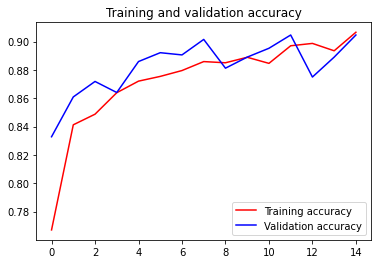

<Figure size 432x288 with 0 Axes>

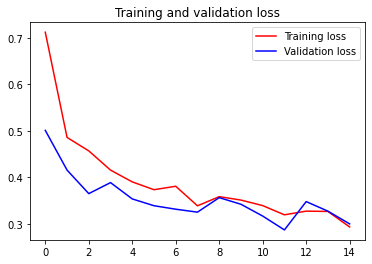

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [18]:
# Checking the indices 
train_generator.class_indices

{'drawings': 0,
 'engraving': 1,
 'iconography': 2,
 'painting': 3,
 'sculpture': 4}